In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from src.graficar import graficar_serie 
from src.ARIMA_experimento import ARIMA_experimento
from src.evaluar import evaluar_forecast

###  Descomposición de la serie ###
from statsmodels.tsa.seasonal import seasonal_decompose

# Correspondiente a un horizonte de 500 muestras

In [2]:
ruta_v1 = 'data/clean_data/v1.csv'
v1 = pd.read_csv(ruta_v1, index_col = 0)
print(v1.shape)
v1.tail()

(1000, 1)


,Valores
995,769.35
996,767.89
997,761.49
998,760.74
999,759.72


In [3]:
ruta_h1 = 'data/clean_data/h1.csv'
h1 = pd.read_csv(ruta_h1, index_col=0)
print(h1.shape)
h1.head()

(500, 1)


,Valores
1000,751.47
1001,752.97
1002,755.53
1003,759.23
1004,760.15


In [4]:
v1.info()
variable = 'Valores'
# 1500 datos limpios

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Valores  1000 non-null   float64
dtypes: float64(1)
memory usage: 15.6 KB


### Ventana

shape: (1000, 1)


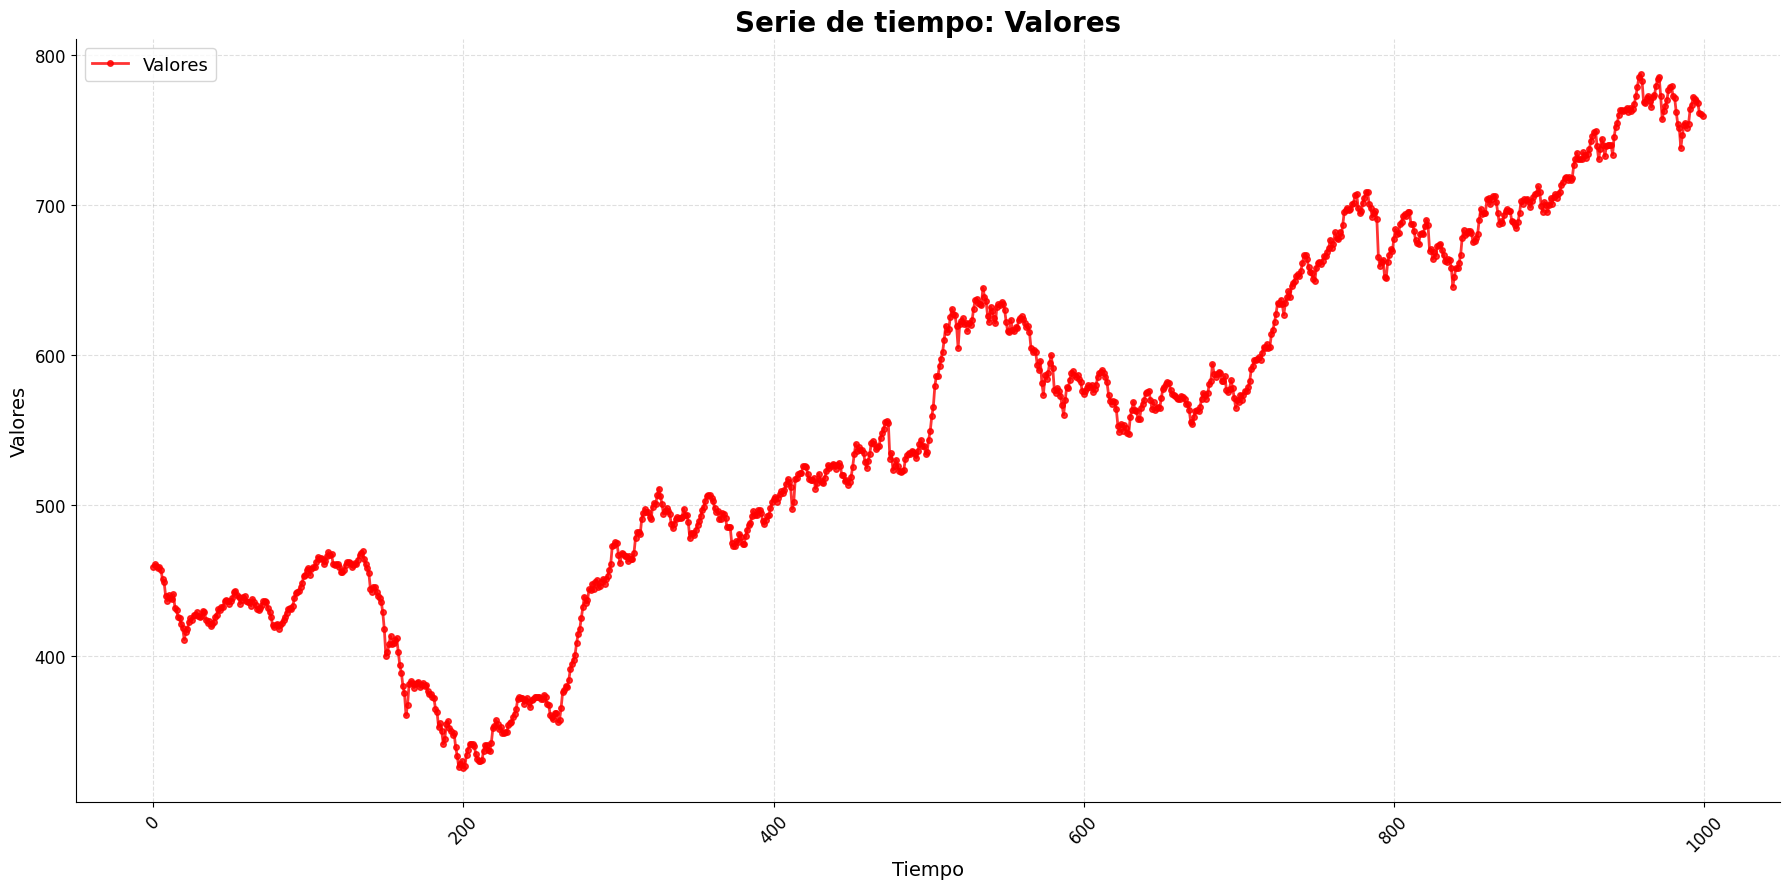

In [5]:
print(f'shape: {v1.shape}')
graficar_serie(v1, variable, color = 'red')
# Claramente podemos ver que antes de aplicar cualquier intento de ARIMA debemos procesar la serie para
# evitar que la no estacionalidad dificulte el aprendizaje de la estructura temporal para los modelos

### Horizonte

shape: (500, 1)


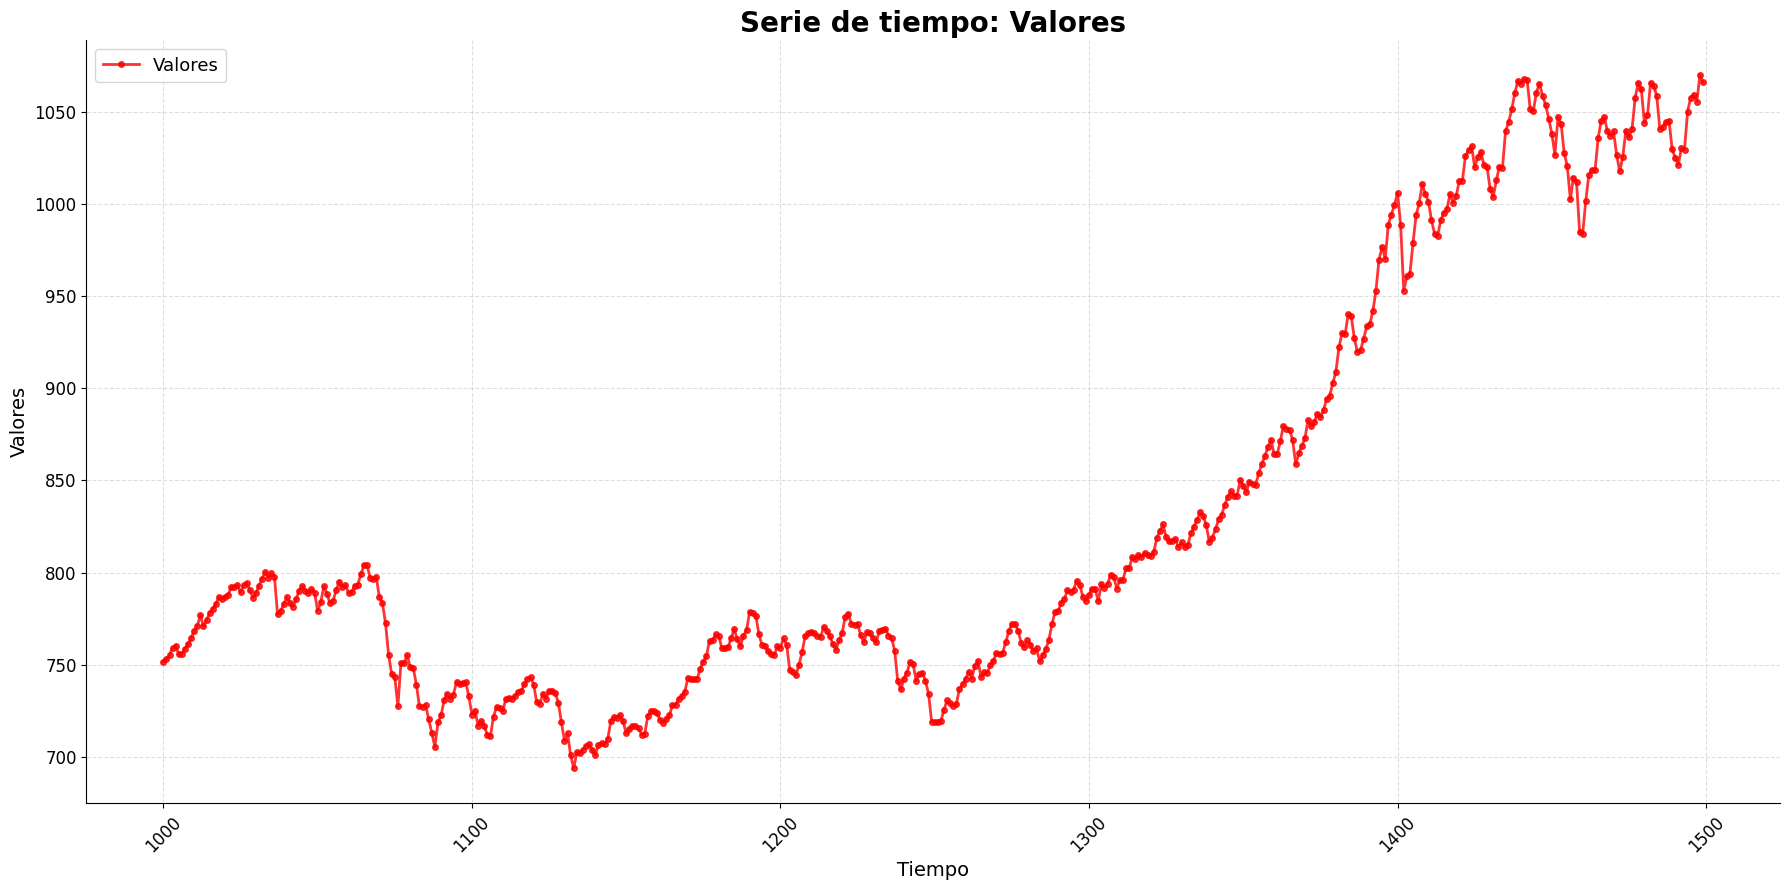

In [6]:
print(f'shape: {h1.shape}')
graficar_serie(h1, variable, color = 'red')
# Esta es la parte que vamos a tratar de predecir

### Descomponer la Ventana

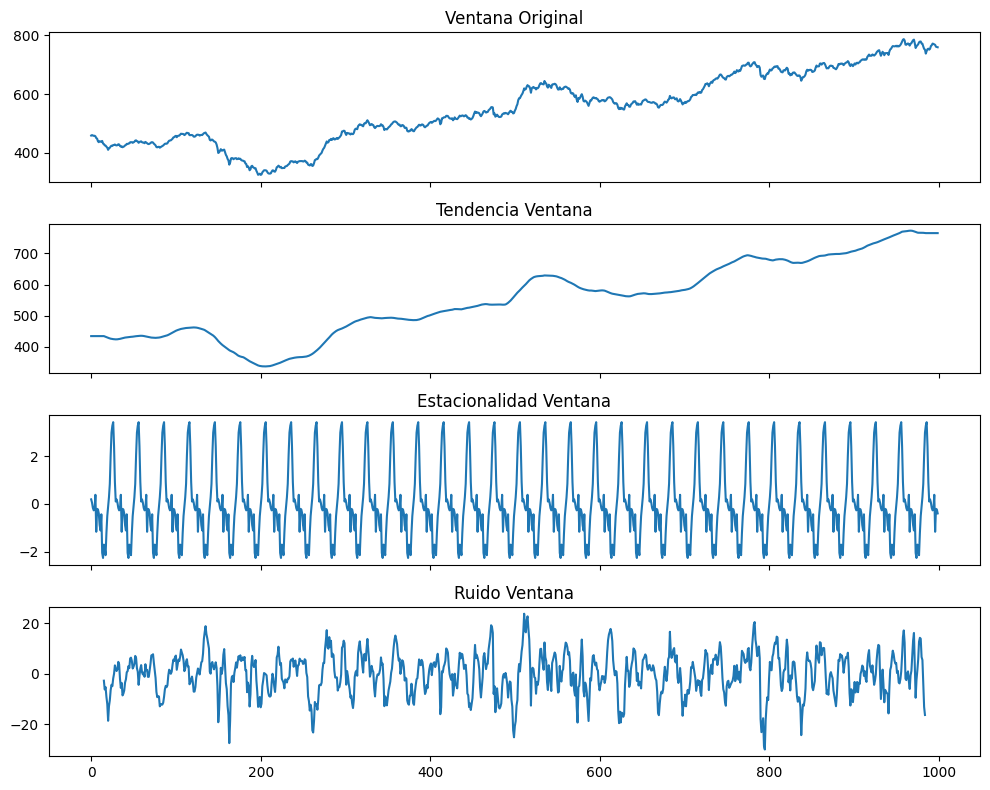

In [ ]:
descomposicion_v = seasonal_decompose(v1['Valores'], model = 'additive', period = 30)

# Definir descomposicion
tendencia_v = descomposicion_v.trend
tendencia_v = tendencia_v.interpolate(method = 'linear', limit_direction = 'both')
estacionalidad_v = descomposicion_v.seasonal
ruido_v = descomposicion_v.resid

# Graficar la descomposición
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

v1['Valores'].plot(ax=ax1, title='Ventana Original')
tendencia_v.plot(ax=ax2, title='Tendencia Ventana')
estacionalidad_v.plot(ax=ax3, title='Estacionalidad Ventana')
ruido_v.plot(ax=ax4, title='Ruido Ventana')

plt.tight_layout()
plt.show()
plt.close()


### Descomponer el Horizonte

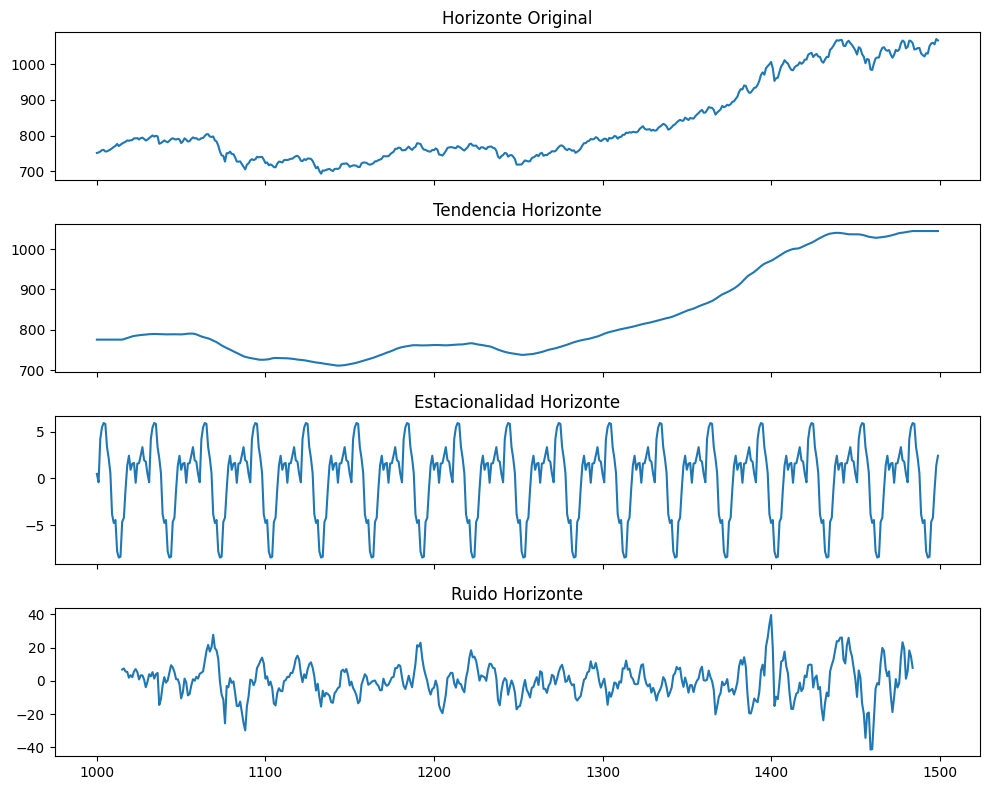

In [21]:
descomposicion_h = seasonal_decompose(h1['Valores'], model = 'additive', period = 30)

tendencia_h = descomposicion_h.trend
tendencia_h = tendencia_h.interpolate(method = 'linear', limit_direction = 'both')
estacionalidad_h = descomposicion_h.seasonal
ruido_h = descomposicion_h.resid

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize = (10, 8), sharex = True)

h1['Valores'].plot(ax = ax1, title = 'Horizonte Original')
tendencia_h.plot(ax = ax2, title = 'Tendencia Horizonte')
estacionalidad_h.plot(ax = ax3, title = 'Estacionalidad Horizonte')
ruido_h.plot(ax = ax4, title = 'Ruido Horizonte')

plt.tight_layout()
plt.show()
plt.close()

shape V1       : (1000, 1)
shape tendencia: (1000,)
shape simple   : (1000, 1)


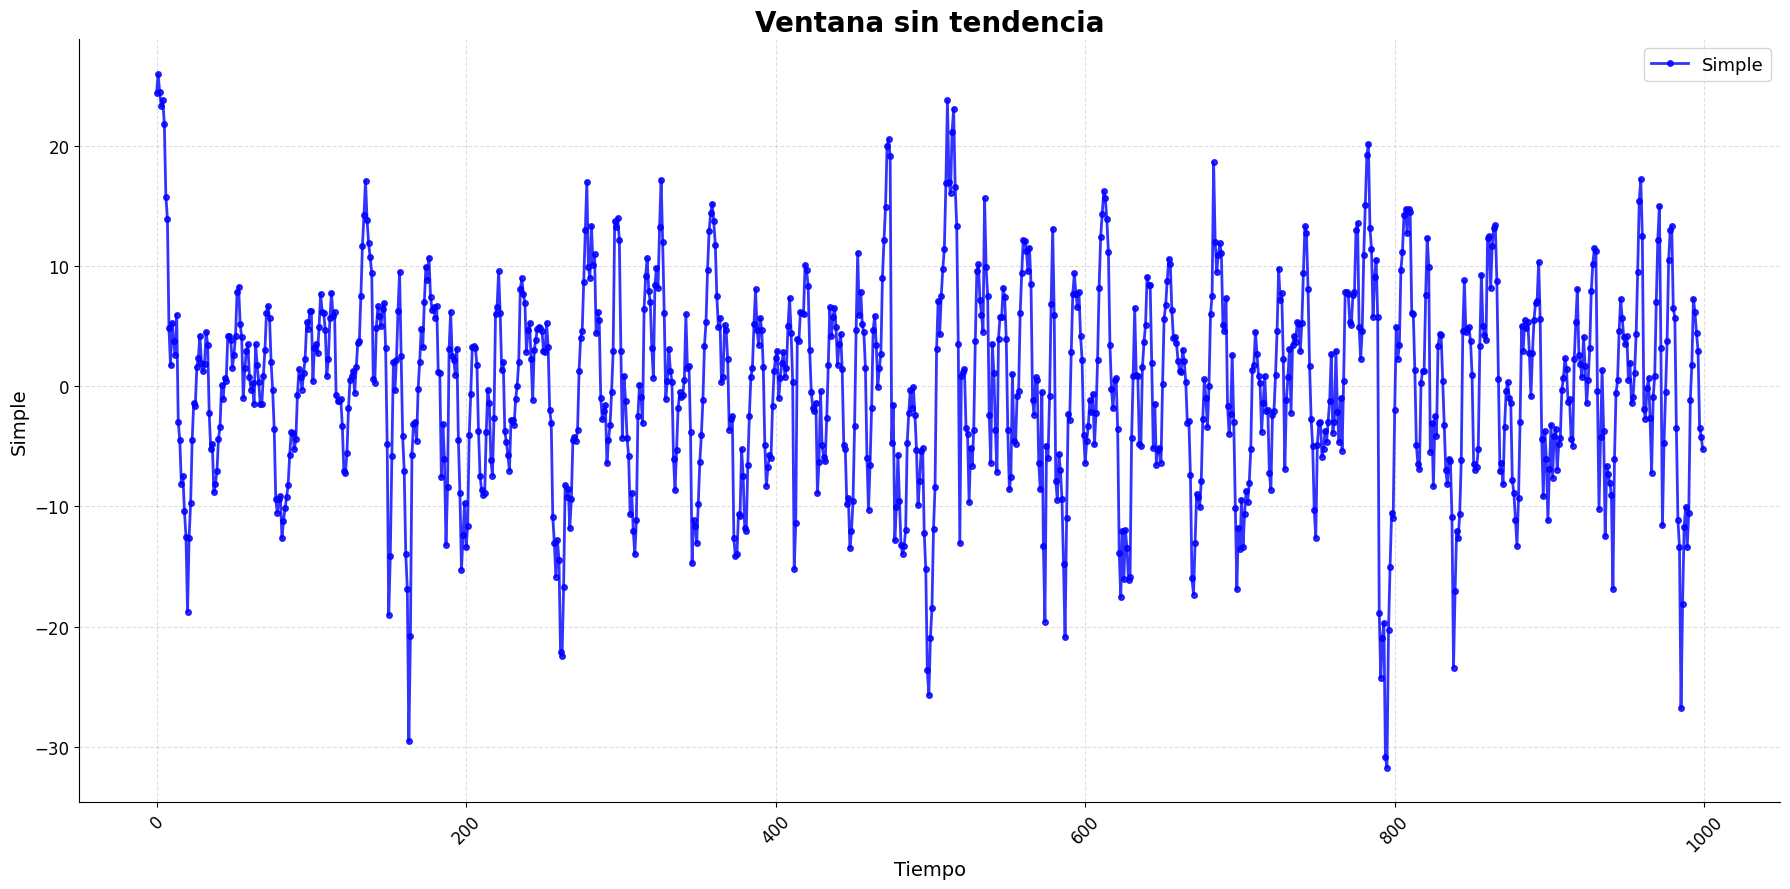

In [23]:
# Vamos a calcular la ventana de predicción pero sin la tendencia, le llamaré simple
simple = v1['Valores'] - tendencia_v
simple = pd.DataFrame(simple, columns = ['Simple'])

print(f'shape V1       : {v1.shape}')
print(f'shape tendencia: {tendencia_v.shape}')
print(f'shape simple   : {simple.shape}')
graficar_serie(simple, 'Simple', color = 'blue', titulo = 'Ventana sin tendencia')

### Experimento 1

/home/jair/anaconda3/envs/series_env/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



 Modelo ARIMA(3,2,3) entrenado exitosamente

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1000
Model:               SARIMAX(3, 2, 3)   Log Likelihood               -2843.172
Date:                Sat, 01 Nov 2025   AIC                           5700.343
Time:                        23:00:56   BIC                           5734.655
Sample:                             0   HQIC                          5713.388
                               - 1000                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8173      0.750      1.090      0.276      -0.652       2.286
ar.L2          0.0026      0.838      0.003      0.998      -1.640       1.645
ar.L3 

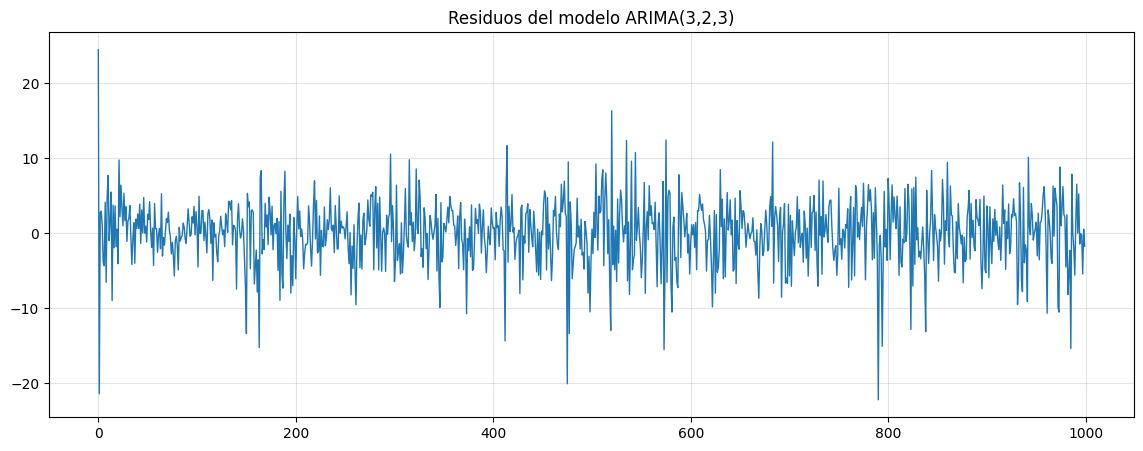

<Figure size 1400x400 with 0 Axes>

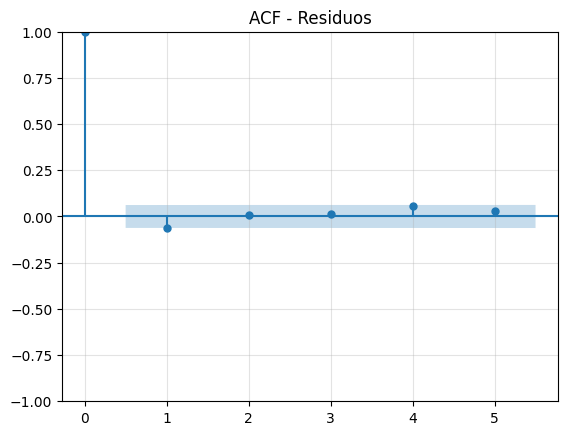

<Figure size 1400x400 with 0 Axes>

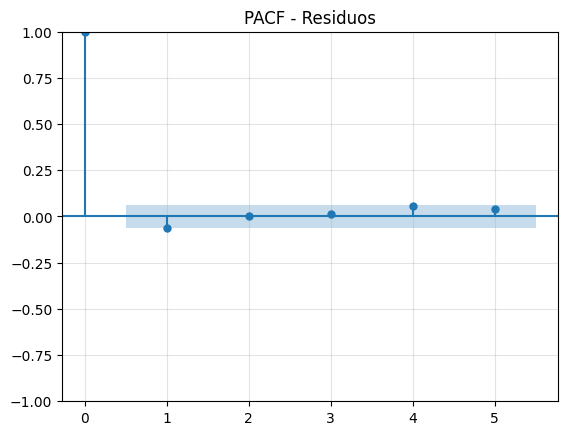


 Test de Ljung - Box ¿Es ruido blanco?

    lb_stat  lb_pvalue
1  4.089842   0.043142
2  4.144236   0.125919
3  4.325503   0.228393
4  7.575081   0.108444
5  8.610704   0.125636

 Interpretacion de la Hipótesis nula

Lag 1: Rechaza Ho, acepta H1 -- Hay correlación en los residuos
Lag 2: No rechaza Ho -- Residuos se comportan como ruido blanco
Lag 3: No rechaza Ho -- Residuos se comportan como ruido blanco
Lag 4: No rechaza Ho -- Residuos se comportan como ruido blanco
Lag 5: No rechaza Ho -- Residuos se comportan como ruido blanco


In [24]:
serie = pd.Series(simple['Simple'].values, index=v1.index)
p = 3
d = 2
q = 3
resultado, residuos = ARIMA_experimento(serie, p, d, q, 5)

### Forecast

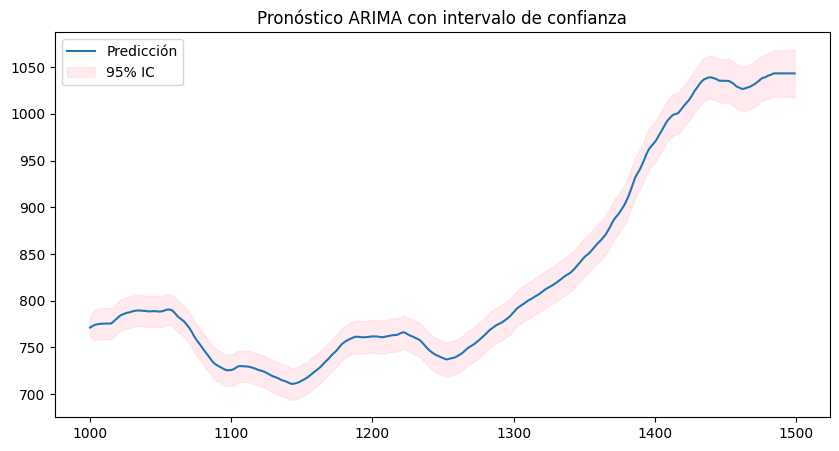

In [25]:
forecast_obj = resultado.get_forecast(steps=len(h1))

# Extraer la media predicha y alinear índices
forecast_std = forecast_obj.predicted_mean
forecast_std.index = h1.index

# Regresar el forecast a la escala de el horizonte
forecast_reescalado = forecast_std + tendencia_h

# Extraer intervalo de confianza directamente del objeto
intervalo = forecast_obj.conf_int(alpha=0.05)
intervalo.index = h1.index  # alinear índices con tu horizonte
intervalo = intervalo + tendencia_h.values.reshape(-1, 1)

# Graficar
plt.figure(figsize=(10,5))
plt.plot(forecast_reescalado, label='Predicción')
plt.fill_between(intervalo.index, intervalo.iloc[:, 0], intervalo.iloc[:, 1],
                 color='pink', alpha=0.3, label='95% IC')
plt.legend()
plt.title('Pronóstico ARIMA con intervalo de confianza')
plt.show()


### Evaluar Forescast

In [26]:
print("len(h1):", len(h1))
print("len(forecast.predicted_mean):", len(forecast_reescalado))
print("forecast.predicted_mean.index[:10]")
print("h1.index[:10]")

len(h1): 500
len(forecast.predicted_mean): 500
forecast.predicted_mean.index[:10]
h1.index[:10]


In [27]:
print("forecast.predicted_mean.index[:10]")
print(forecast_reescalado.index[:10].to_list())
print("h1.index[:10]")
print(h1.index[:10].to_list())

forecast.predicted_mean.index[:10]
[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009]
h1.index[:10]
[1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009]


In [28]:
print(f"NaNs en forecast_std: {forecast_std.isna().sum()}")
print(f"NaNs en tendencia_h: {tendencia_h.isna().sum()}")

NaNs en forecast_std: 0
NaNs en tendencia_h: 0


In [30]:
y_true = np.array(h1.values).flatten()
y_pred = np.array(forecast_reescalado).flatten()

print(f'shape Y_True : {y_true.shape}')
print(f'shape Y_Pred : {y_pred.shape}')

medidas = evaluar_forecast(y_true, y_pred)

for nombre, valor in medidas.items():
    print(f'{nombre} : {np.round(valor, 4)}')

shape Y_True : (500,)
shape Y_Pred : (500,)
RMSE : 11.2277
SMAPE : 1.0199
R2_Pearson : 0.9901


### Graficar

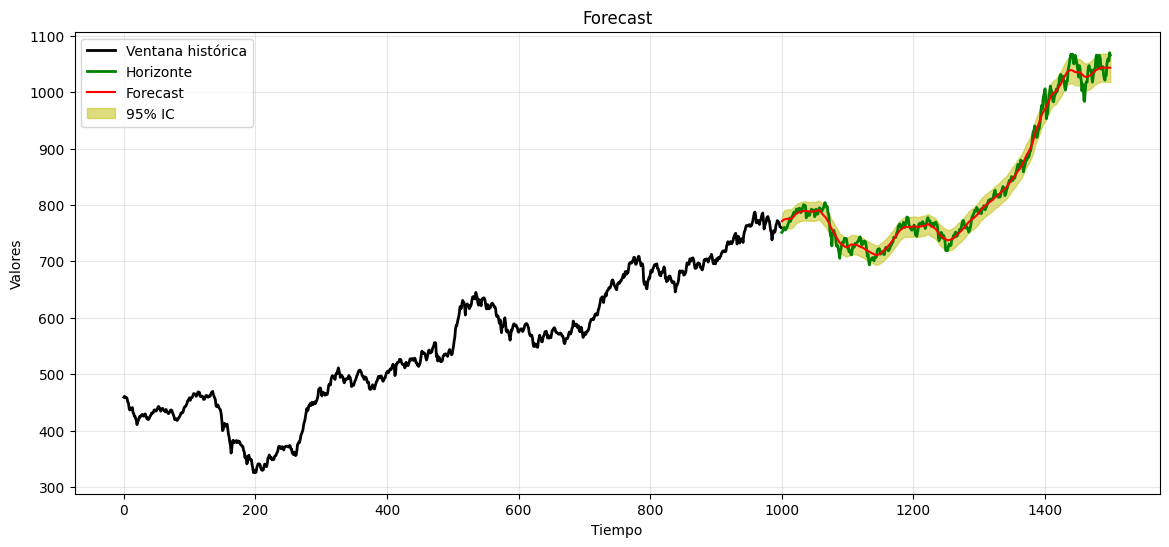

In [57]:
n_ventana = len(v1)
n_horizonte = len(h1)
idx_ventana = np.arange(n_ventana)
idx_horizonte = np.arange(n_ventana, n_ventana + n_horizonte)

plt.figure(figsize=(14,6))
plt.plot(idx_ventana, v1.values, label='Ventana histórica', color='black', linewidth=2)
plt.plot(idx_horizonte, h1.values, label='Horizonte', color='green', linewidth=2)
plt.plot(idx_horizonte, forecast_reescalado, label='Forecast', color='r', linewidth=1.5)

plt.fill_between(intervalo.index, intervalo.iloc[:, 0], intervalo.iloc[:, 1],
                 color='y', alpha=0.5, label='95% IC')
plt.xlabel('Tiempo')
plt.ylabel('Valores')
plt.title('Forecast')
plt.legend()
plt.grid(alpha=0.3)
plt.show()